# Linear Regression Exercises

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
import scipy
from scipy import stats

What do I want people to do

* Load palmer penguins
* Run a linear regression on weight on just Adelie penguins
* Use posterior predictive to understand how many penguins are above X grams
* Use two other features to predict penguin mass

* Expand regression to all species, just using bill length
  * How many beta parameters do we have now?
  * What is the slope of each

## Load Penguins Dataset

In [2]:
penguins = pd.read_csv("https://raw.githubusercontent.com/BayesianModelingandComputationInPython/BookCode_Edition1/main/data/penguins.csv")

In [3]:
missing_data = penguins.isnull()[
    ["bill_length_mm", "flipper_length_mm", "sex", "body_mass_g"]
].any(axis=1)

# Drop rows with any missing data
penguins = penguins.loc[~missing_data]

In [4]:
penguins.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,male,2007


### Set random seed
Just for reproducibility in this class

In [5]:
RANDOM_SEED = 8296

## Exercise 1: Intercept only regression
The Palmer Penguin dataset has been loaded for you. For the first exercise we want to focus just on the Adelie penguins. 

Specifically we would like you to

1. Perform some exploratory data analysis to get a sense of the data
2. Filter to only observations Adelie penguins that have *complete* data
2. Write the model for an intercept only regression for `body_mass_g`
3. Sample from the prior predictive
4. Use MCMC sampling to estimate the model parameters
5. Using the ArviZ posterior plot, plot the posterior estimates
   * What is the 75% HDI for these parameters
6. Plot the posterior predictive
  * How does it compare to the prior predictive?


In [6]:
adelie_mask = (penguins["species"] == "Adelie")
adelie_penguins = penguins[adelie_mask]

In [7]:
with pm.Model() as penguin_simple:
    intercept = pm.Normal("intercept", 0, 10000)
    eps = pm.HalfNormal("eps", 100)

    pm.Normal(
        "weight",
        mu=intercept,
        sigma=eps,
        observed=adelie_penguins["body_mass_g"]
    )
    idata_simple = pm.sample(random_seed=RANDOM_SEED)
    idata_simple.extend(pm.sample_prior_predictive(random_seed=RANDOM_SEED))
    idata_simple.extend(pm.sample_posterior_predictive(idata_simple, random_seed=RANDOM_SEED))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, eps]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.
Sampling: [eps, intercept, weight]
Sampling: [weight]


/home/oriol/bin/miniforge3/envs/intuitive_bayes/lib/python3.11/site-packages/arviz/plots/ppcplot.py:267: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  flatten_pp = list(predictive_dataset.dims.keys())
/home/oriol/bin/miniforge3/envs/intuitive_bayes/lib/python3.11/site-packages/arviz/plots/ppcplot.py:271: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  flatten = list(observed_data.dims.keys())


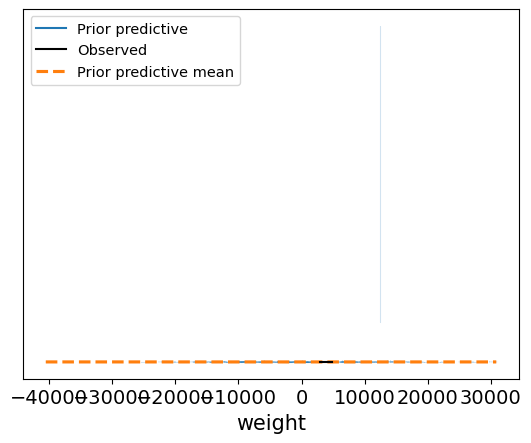

In [8]:
az.plot_ppc(idata_simple, group="prior");

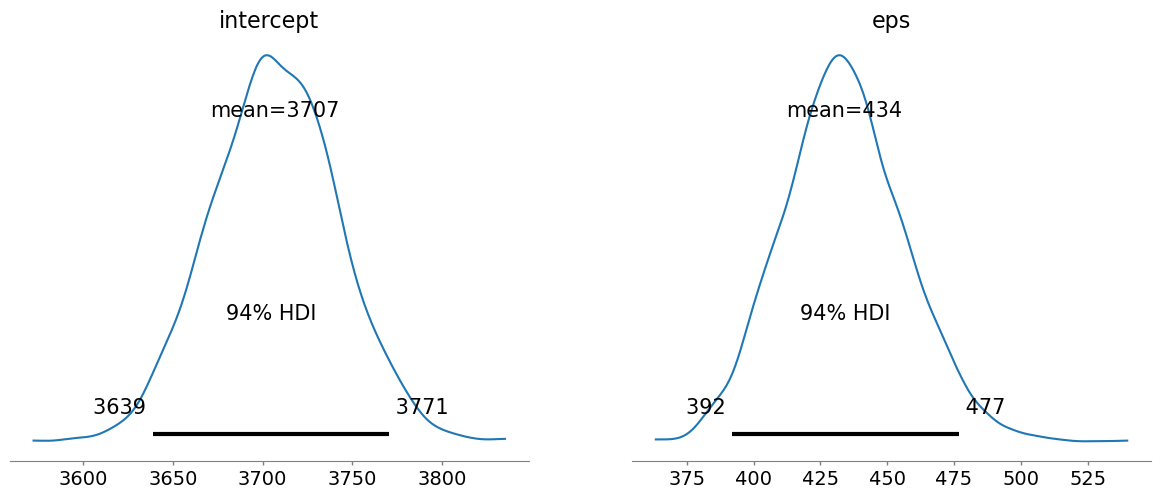

In [9]:
az.plot_posterior(idata_simple, var_names=["intercept", "eps"]);

/home/oriol/bin/miniforge3/envs/intuitive_bayes/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/oriol/bin/miniforge3/envs/intuitive_bayes/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


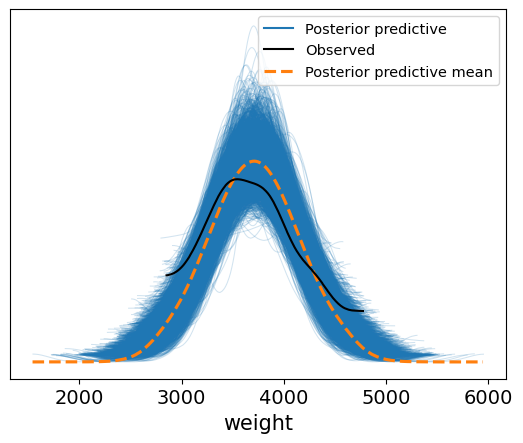

In [10]:
az.plot_ppc(idata_simple, group="posterior");

## Exercise 2: Adding Regressors

Still using the Adelie dataset perform two regressions. [This diagram](https://github.com/allisonhorst/palmerpenguins#bill-dimensions) will give you an intuition for what each means.

_Hint_: In plotting the posterior the `var_names` argument is quite helpful to focus on what you plots you care about

1. Perform a regression with `bill_length_mm` only
2. Perform a regression with `bill_length_mm` and `bill_depth_mm`

For each regression plot the posterior parameters  

### Single Regression

In [11]:
COORDS = {
    "slopes": ["bill_length_mm"],
}

In [12]:
with pm.Model(coords=COORDS) as adelie_regression:
    
    length = pm.MutableData("bill_length_mm", adelie_penguins["bill_length_mm"].values)
    
    # priors
    intercept = pm.Normal("intercept", sigma=1000)
    β = pm.Normal("β", sigma=100, dims=("slopes"))

    
    # linear regression
    mu = (
        intercept
        + β[0] * length
    )
    # observational noise
    eps = pm.HalfNormal("eps", 100)
    
    # likelihood
    pm.Normal(
        "obs",
        mu=mu,
        sigma=eps,
        observed=adelie_penguins["body_mass_g"].values
    )
    idata_regression = pm.sample(random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, β, eps]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.


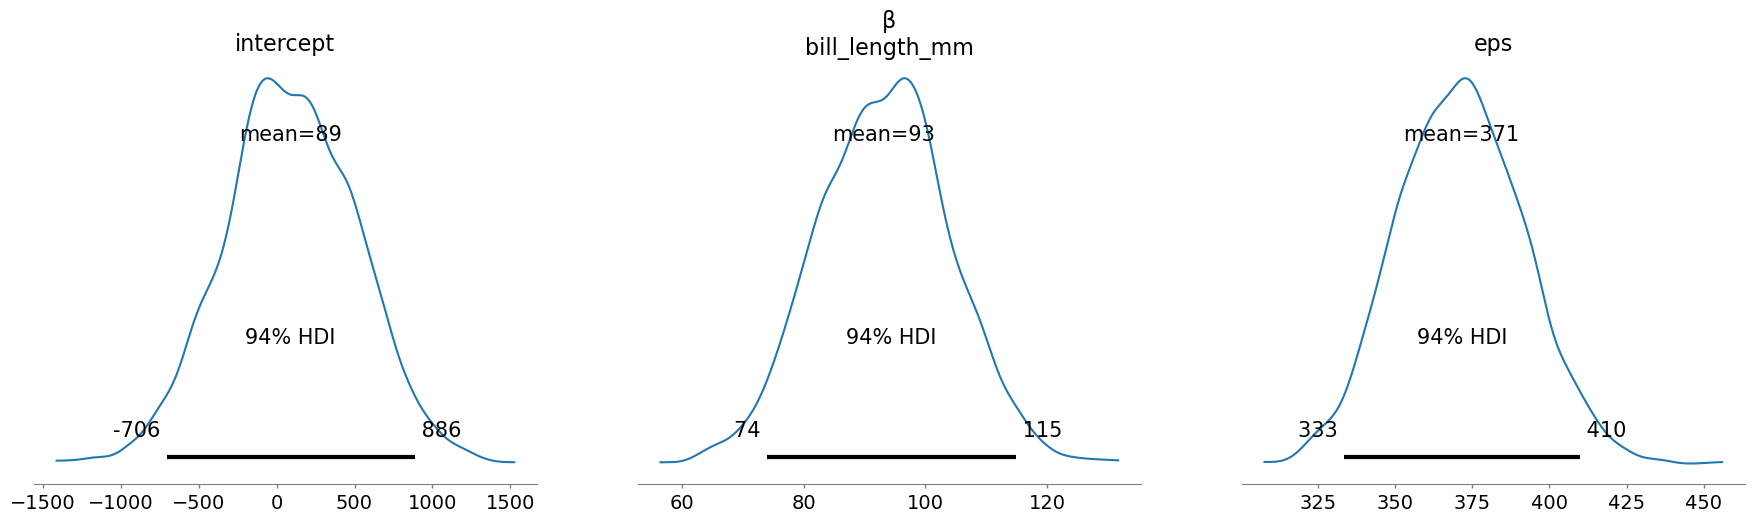

In [13]:
az.plot_posterior(idata_regression, var_names=["intercept", "β", "eps"]);

### Multiple Regression

In [14]:
COORDS = {
    "slopes": ["bill_length_mm", "bill_depth_mm"]
}

In [15]:
with pm.Model(coords=COORDS) as adelie_regression:

    # priors
    intercept = pm.Normal("intercept", sigma=100)
    β = pm.Normal("β", sigma=1000, dims=("slopes"))  

    # linear regression
    mu = (
        intercept
        + β[0] * adelie_penguins["bill_length_mm"].values
        + β[1] * adelie_penguins["bill_depth_mm"].values
    )
    
    # observational noise
    eps = pm.HalfNormal("eps", 100)
    
    # likelihood
    pm.Normal(
        "obs",
        mu=mu,
        sigma=eps,
        observed=adelie_penguins["body_mass_g"].values
    )
    idata_regression = pm.sample(random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, β, eps]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.


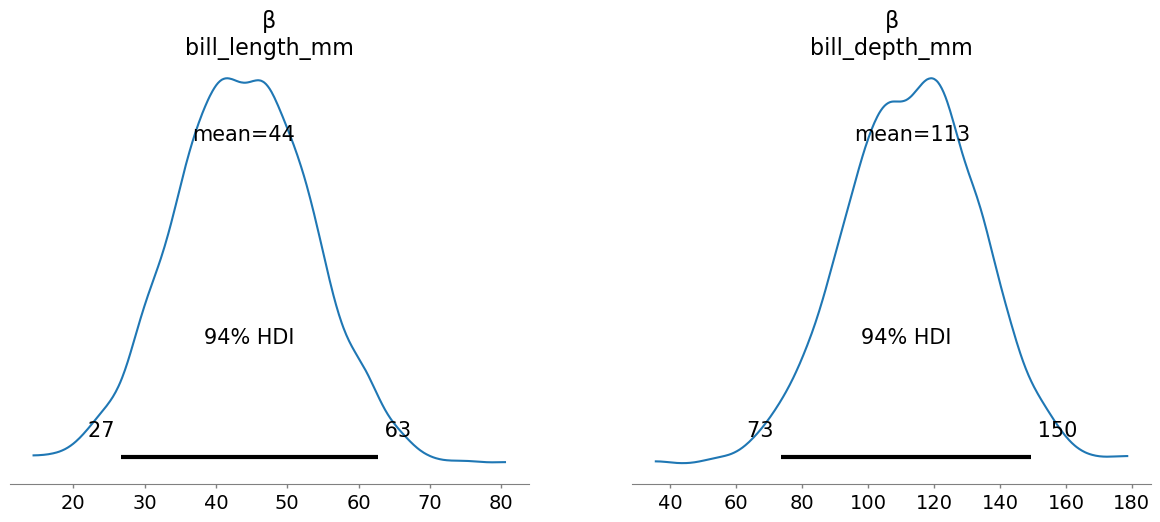

In [16]:
az.plot_posterior(idata_regression, var_names=["β"]);

## Exercise 3: Multiple Species
In this exercise we'll introduce all the species and perform a regression for each.

* Expand the regression to include all penguins still using `bill_length_mm` and `bill_depth_mm` as the regressors
* Plot the posterior distribution. Verify the slopes for the Adelie penguins are the same as the previous model
  * `Hint`: the `.sel` xarray slicing will be helpful here

In [17]:
species_idx, species = penguins["species"].factorize(sort=True)

COORDS = {
    "slopes": ["bill_length_mm", "bill_depth_mm"],
    "species": species,

}

In [18]:
with pm.Model(coords=COORDS) as penguin_regression:
    
    length = pm.MutableData("bill_length_mm", penguins["bill_length_mm"].values)
    depth = pm.MutableData("bill_depth_mm", penguins["bill_depth_mm"].values)
    species_idx_ = pm.ConstantData("species_idx", species_idx)

    
    # priors
    intercept = pm.Normal("intercept", sigma=100, dims=("species"))
    β = pm.Normal("β", sigma=1000, dims=("species", "slopes"))

    
    # linear regression
    mu = (
        intercept[species_idx_]
        + β[species_idx_, 0] * length
        + β[species_idx_, 1] * depth
    )
    # observational noise
    eps = pm.HalfNormal("eps", 100)
    
    # likelihood
    pm.Normal(
        "obs",
        mu=mu,
        sigma=eps,
        observed=penguins["body_mass_g"].values
    )
    idata_regression = pm.sample(random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, β, eps]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 38 seconds.


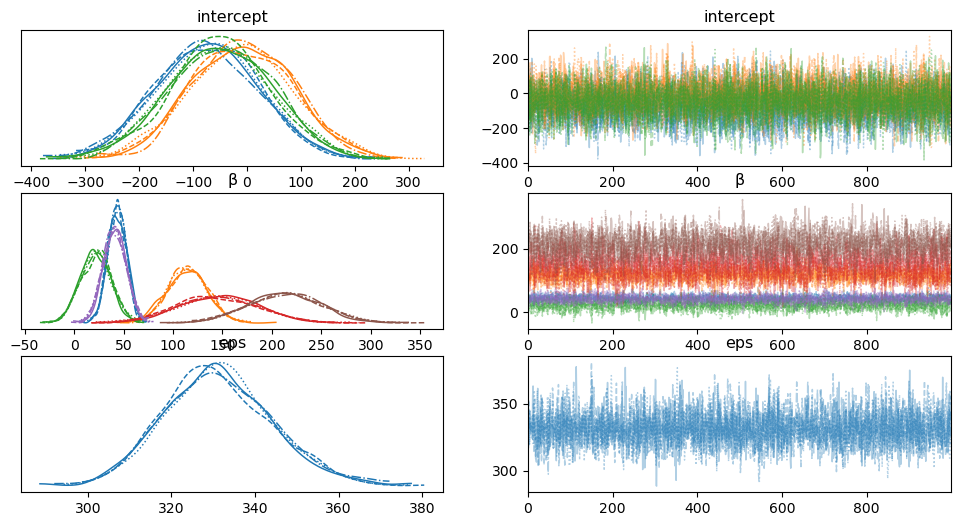

In [19]:
az.plot_trace(idata_regression);

In [20]:
idata_regression.posterior

<xarray.Dataset> Size: 328kB
Dimensions:    (chain: 4, draw: 1000, species: 3, slopes: 2)
Coordinates:
  * chain      (chain) int64 32B 0 1 2 3
  * draw       (draw) int64 8kB 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
  * species    (species) <U9 108B 'Adelie' 'Chinstrap' 'Gentoo'
  * slopes     (slopes) <U14 112B 'bill_length_mm' 'bill_depth_mm'
Data variables:
    intercept  (chain, draw, species) float64 96kB -61.03 -24.7 ... 22.06 -70.47
    β          (chain, draw, species, slopes) float64 192kB 46.16 ... 248.5
    eps        (chain, draw) float64 32kB 347.7 316.8 332.9 ... 326.9 319.5
Attributes:
    created_at:                 2024-02-19T19:28:54.617176
    arviz_version:              0.17.0
    inference_library:          pymc
    inference_library_version:  5.10.4
    sampling_time:              38.101096630096436
    tuning_steps:               1000

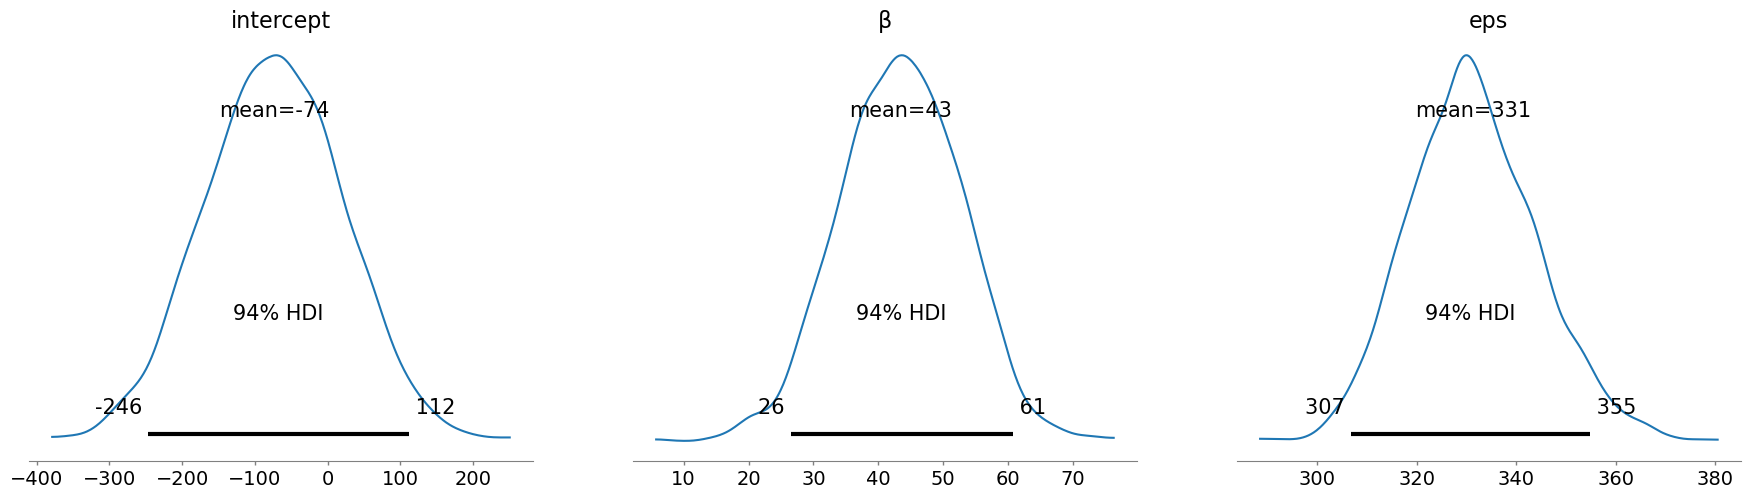

In [21]:
az.plot_posterior(idata_regression, coords={"species": "Adelie", "slopes": "bill_length_mm"});

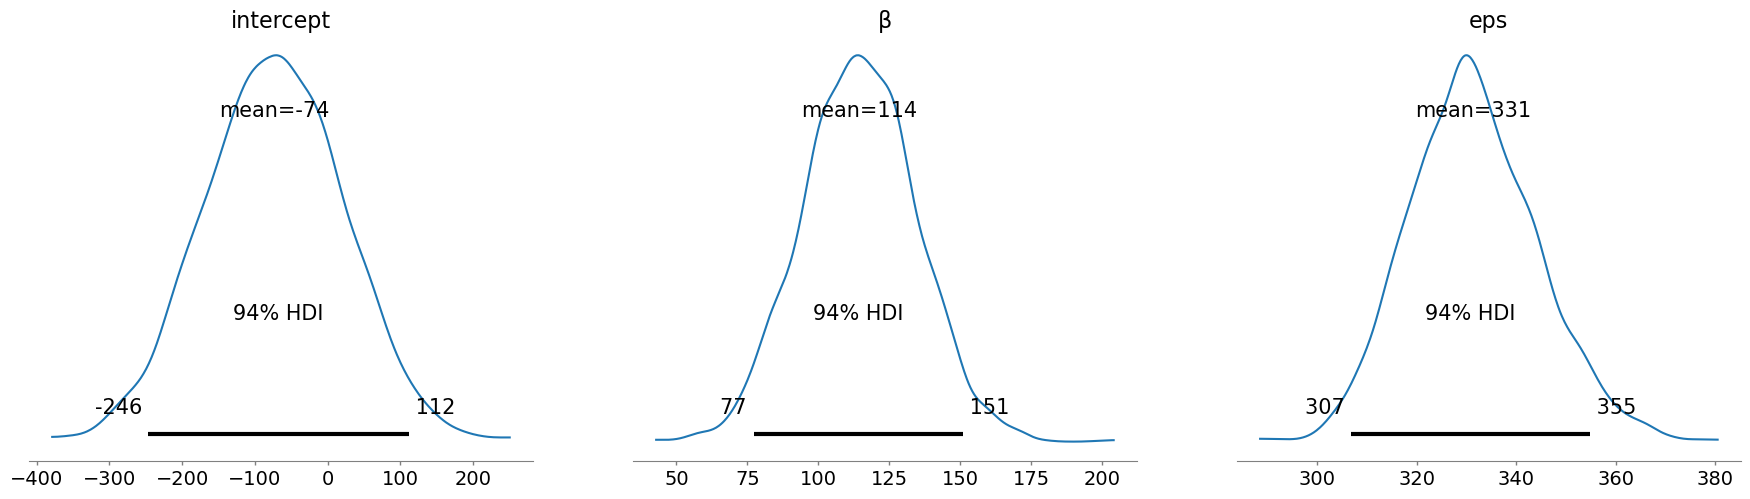

In [22]:
az.plot_posterior(idata_regression.posterior.sel(species="Adelie", slopes="bill_depth_mm"));